# Plot Malignancy Estimation Results

Code adapted from the following repositories:

* [Kiran model](https://github.com/DIAGNijmegen/bodyct-nodule-malignancy)
* [Thijmen model](https://github.com/DIAGNijmegen/bodyct-lung-malignancy)
* [StackOverflow on right-align legend text](https://stackoverflow.com/questions/7936034/text-alignment-in-a-matplotlib-legend)

In [1]:
import pandas as pd
import os
import numpy as np

import seaborn as sns
sns.set_style("white")
from evalutils.roc import get_bootstrapped_roc_ci_curves
import matplotlib.pyplot as plt

%matplotlib inline
import sklearn.metrics as skl_metrics

## Read Data (DLCST results)

In [2]:
## Read DLCST results
df_results = pd.read_csv("dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
df_results.head()

,PatientID,StudyDate,SeriesInstanceUID,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
0,4,20050124,1.2.840.113704.1.111.4964.1106577805.10,55,2,0,0,9,0.021629,0.038573,0.071919,0.079270,0.095846,0.135681,0.053366,0.082652,0.166209,0
1,35,20051208,1.2.840.113704.1.111.5776.1134059140.11,56,1,1,1,2,0.001170,0.002554,0.007835,0.011039,0.018442,0.030460,0.009543,0.000408,0.003368,0
2,38,20060109,1.2.840.113704.1.111.2004.1136823831.14,62,2,0,1,4,0.001784,0.003870,0.007835,0.012797,0.019229,0.032957,0.006734,0.002702,0.065888,0
3,47,20051214,1.2.840.113704.1.111.8148.1134579622.14,57,1,0,1,1,0.003951,0.015674,0.025373,0.034010,0.040605,0.058852,0.007944,0.084158,0.423341,0
4,56,20051213,1.2.840.113704.1.111.2744.1134487263.11,64,1,0,1,3,0.000000,0.001574,0.003791,0.006847,0.010381,0.017287,0.000899,0.000013,0.005590,0


In [3]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [4]:
df_results.describe()

,PatientID,StudyDate,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,PanCan2b,Ensemble_Kiran,thijmen_mean,label
count,599.000000,5.990000e+02,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,599.000000,5.990000e+02,599.000000,599.000000
mean,1883.756260,2.005100e+07,58.397329,1.460768,0.170284,0.676127,1.769616,0.025965,0.040542,0.050433,0.058651,0.067412,0.089968,0.055902,1.461987e-01,0.166094,0.098497
std,1215.815006,7.593265e+03,4.946103,0.498875,0.376196,0.468343,1.165421,0.080576,0.104781,0.111505,0.115754,0.121409,0.135617,0.118722,2.966031e-01,0.241460,0.298235
min,4.000000,2.004111e+07,50.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.820000e-07,0.000574,0.000000
25%,800.500000,2.005013e+07,54.000000,1.000000,0.000000,0.000000,1.000000,0.001170,0.002554,0.007835,0.012797,0.019229,0.032957,0.002396,2.369950e-04,0.011600,0.000000
50%,1689.000000,2.005052e+07,58.000000,1.000000,0.000000,1.000000,1.000000,0.001965,0.005733,0.010996,0.015721,0.021112,0.035951,0.007804,2.825316e-03,0.045436,0.000000
75%,3011.500000,2.005103e+07,62.000000,2.000000,0.000000,1.000000,2.000000,0.007145,0.020146,0.029786,0.039906,0.051451,0.076318,0.044897,6.282042e-02,0.201205,0.000000
max,4099.000000,2.009122e+07,75.000000,2.000000,1.000000,1.000000,9.000000,0.838213,0.903660,0.902390,0.914693,0.914693,0.914693,0.789437,9.988375e-01,0.977596,1.000000


<Axes: xlabel='Age', ylabel='Count'>

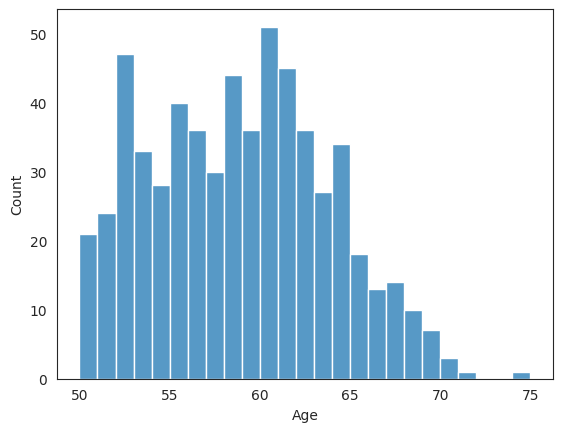

In [5]:
sns.histplot(df_results, x="Age", bins=25)

### Define DLCST Splits
DataFrame queries for subsets. Can use this for plots and whatnot.

In [22]:
SPLIT_QUERIES = {
    "sex": {
        "male": 'Sex == 1',
        "female": 'Sex == 2' 
    },
    "family history": {
        "no": 'FamilyHistoryLungCa == 0',
        "yes": 'FamilyHistoryLungCa == 1' 
    },
    "emphysema": {
        "no": 'Emphysema == 0',
        "yes": 'Emphysema == 1' 
    },
    "age": {
        "50-55": '50 <= Age < 55',
        "55-60": '55 <= Age < 60', 
        "60-65": '60 <= Age < 65', 
        "65+": '65 <= Age', 
    }
}

In [23]:
def get_split_dfs(df, split_by="sex"):
    subset_dfs = {}
    for (split, query) in SPLIT_QUERIES[split_by].items():
        subset_dfs[split] = df.query(query)
        print(f"{split}, n={len(subset_dfs[split])}")
    return subset_dfs

## ROC Plots

### Utility Code

In [6]:
## Plot settings (adapted from Kiran and Thijmen's repos)
sns.set_theme(
    "talk",
    "whitegrid",
    "dark",
    rc={"lines.linewidth": 2, "grid.linestyle": "--"},
)
color_palette = sns.color_palette("colorblind")

In [7]:
def plot_rocs(rocs, title=None, imgpath=None, plot_ci=False):
    plt.figure(figsize=(8,8))
    plt.plot([0.0, 1.0], [0.0, 1.0], "--", color="k", alpha=0.5)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xticks(np.arange(0, 1.1, 0.1), fontsize=12)  # X axis ticks in steps of 0.1
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=12)  # Y axis ticks in steps of 0.1
    plt.grid(lw=1)
    plt.xlim(-0.005,1)
    plt.ylim(0,1.005)

    for i, label in enumerate(rocs):
        roc = rocs[label]
        # roc = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[m]].values, df[true_col].values)
        auc = skl_metrics.auc(roc.fpr_vals, roc.mean_tpr_vals)
        plt.plot(
            roc.fpr_vals, roc.mean_tpr_vals, color=color_palette[i],
            label=f"{label}: AUC = {auc:.3f} (95% CI: {roc.low_az_val:.3f} - {roc.high_az_val:.3f})",
        )
        if plot_ci:
            plt.fill_between(roc.fpr_vals, roc.low_tpr_vals, roc.high_tpr_vals, color=color_palette[i], alpha=.1)

    if title:
        plt.title(title, fontsize=14)

    leg = plt.legend(loc='lower right', fontsize=12)
    shift = max([t.get_window_extent().width for t in leg.get_texts()])
    for t in leg.get_texts():
        t.set_ha('right') # ha is alias for horizontalalignment
        t.set_position((shift - t.get_window_extent().width,0))

    if imgpath is not None:
        plt.savefig(imgpath, dpi=600)
    plt.show()

### Compare ROCs across models

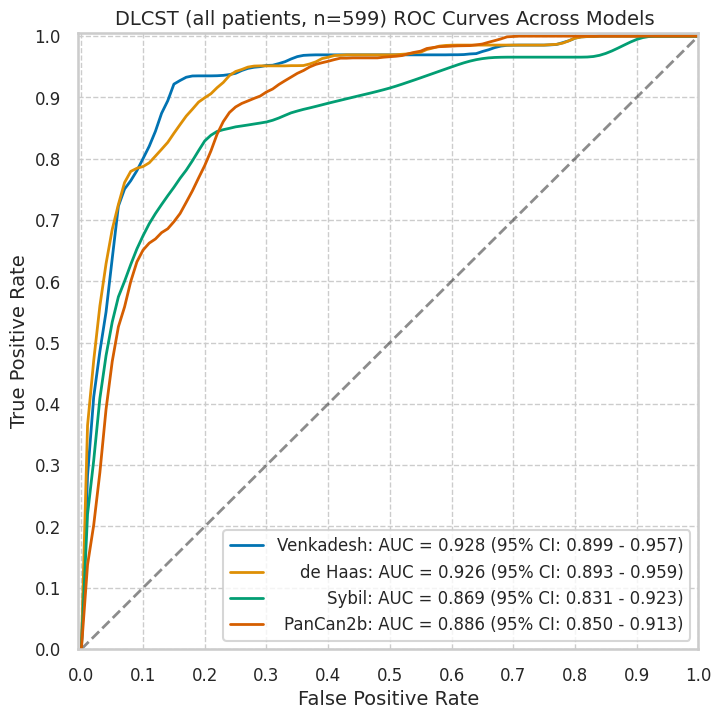

In [8]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

def rocs_models(df, true_col='label', models=["Venkadesh", "de Haas", "Sybil", "PanCan2b"], dataset_label="DLCST", subset_label="all", imgpath=None, plot_ci=False):
    rocs = {}
    for m in models:
        rocs[m] = get_bootstrapped_roc_ci_curves(df[MODEL_TO_COL[m]].values, df[true_col].values)
    
    plot_rocs(rocs, f'{dataset_label} ({subset_label} patients, n={len(df)}) ROC Curves Across Models ', imgpath, plot_ci)

rocs_models(df_results)

### Compare Model Performance For Each Split

male, n=323
female, n=276


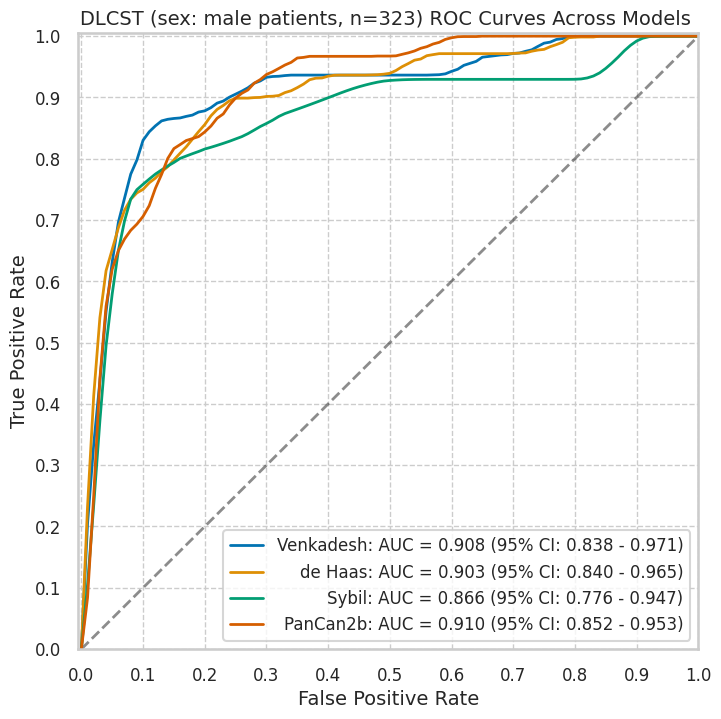

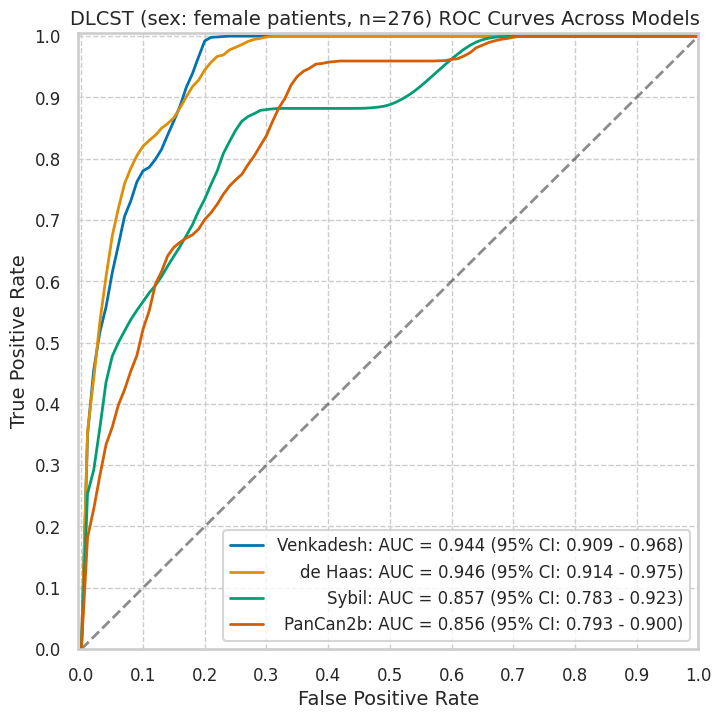

no, n=497
yes, n=102


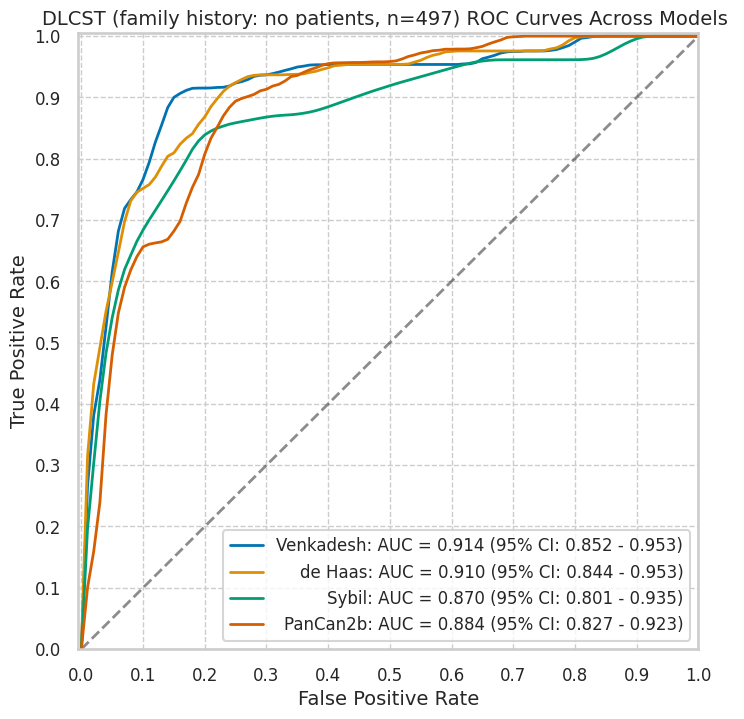

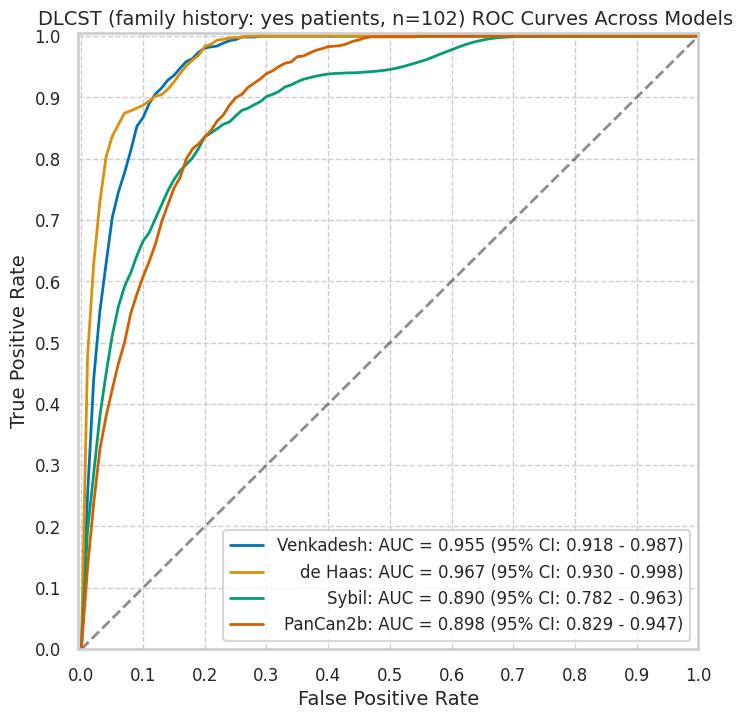

no, n=194
yes, n=405


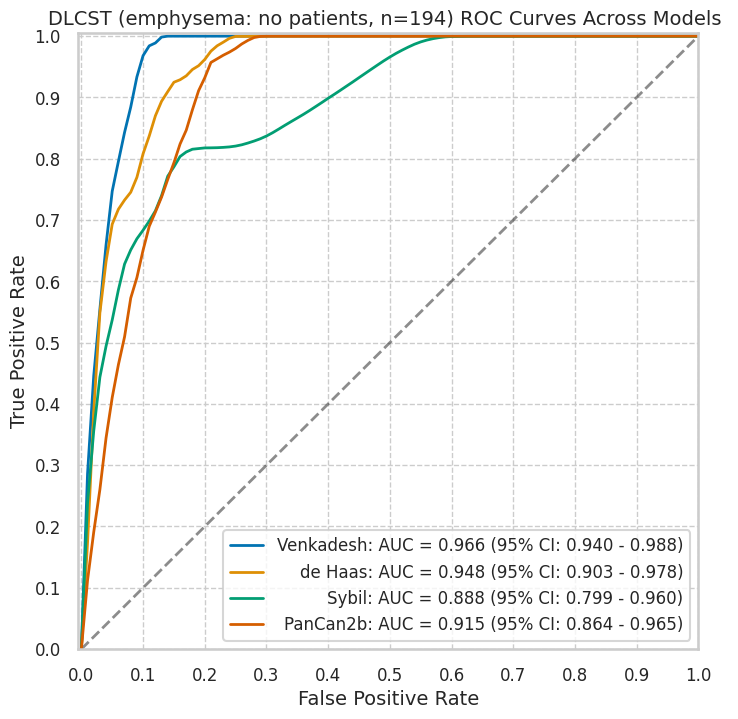

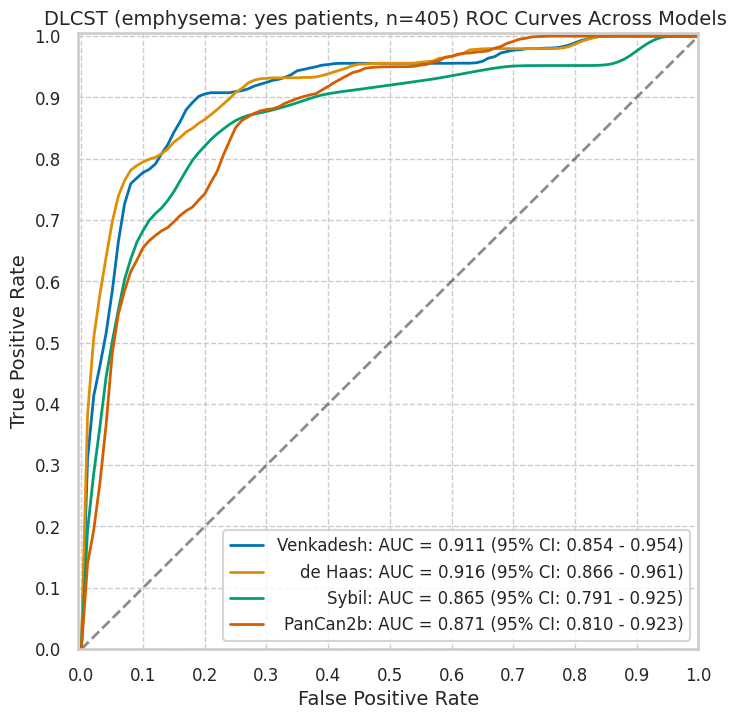

50-55, n=153
55-60, n=186
60-65, n=193
65+, n=67


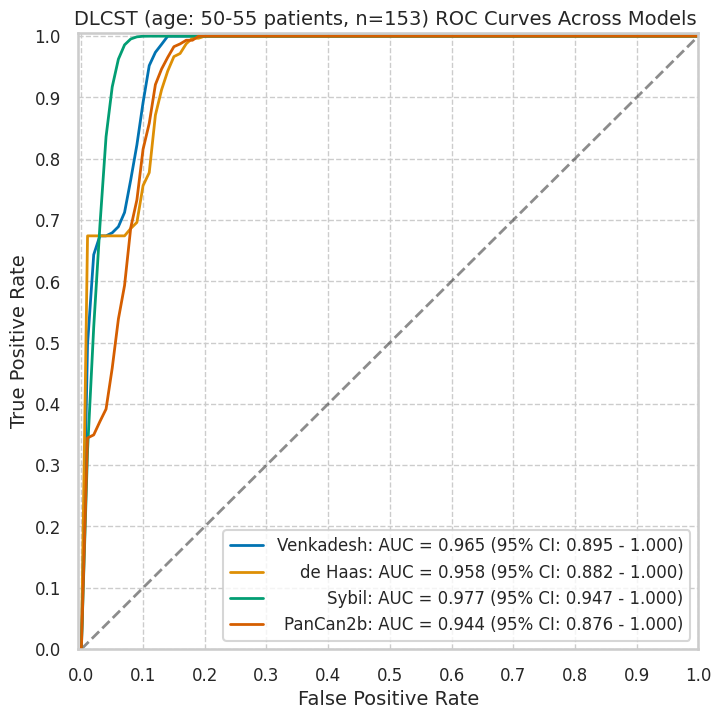

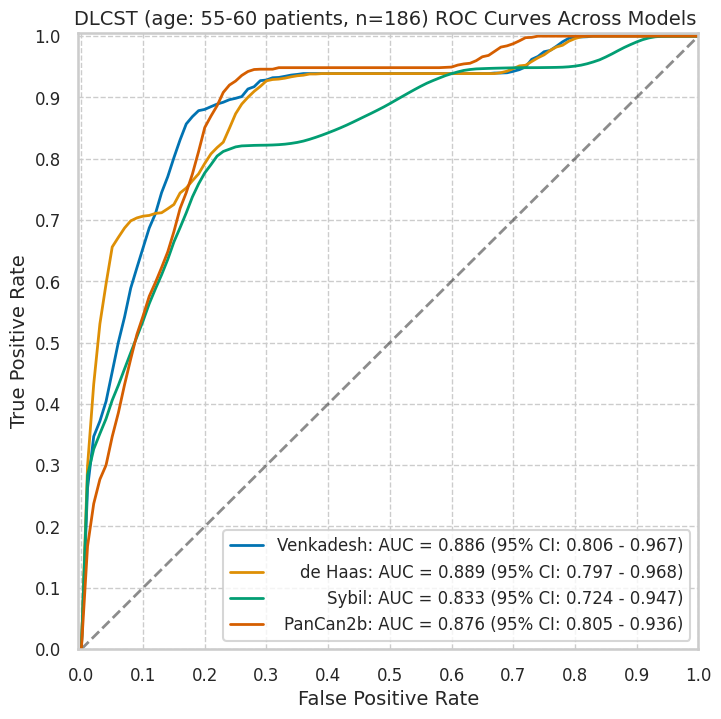

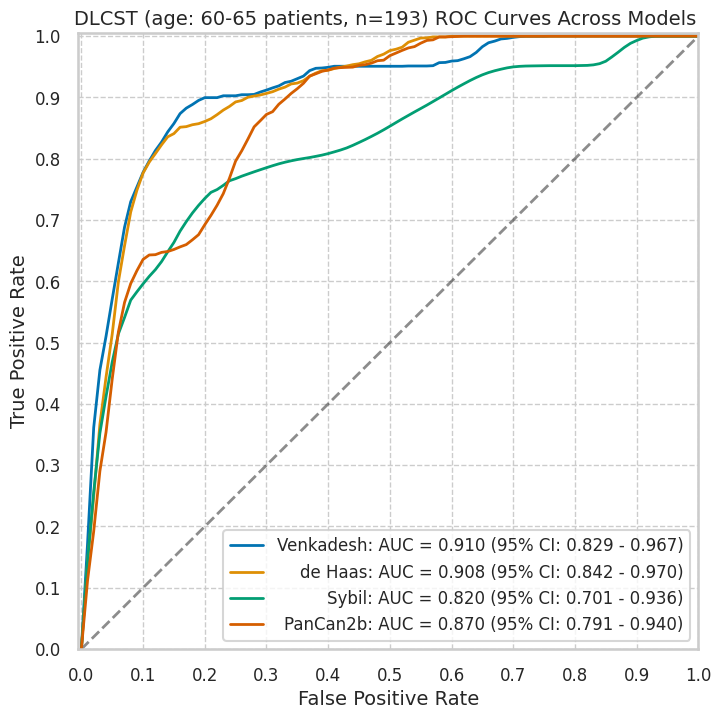

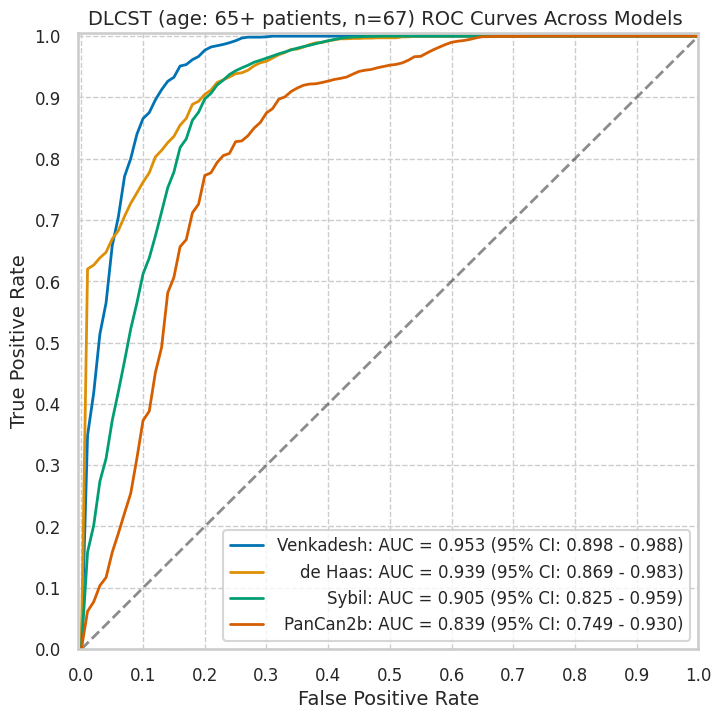

In [11]:
for split_type in SPLIT_QUERIES:
    subset_dfs = get_split_dfs(df_results, split_by=split_type)
    for split, df_sub in subset_dfs.items():
        rocs_models(df_sub, subset_label=f'{split_type}: {split}')

### Plot Splits for Same Model

In [17]:
def rocs_splits(df, split_by="sex", dataset_label="DLCST", true_col='label', model="Venkadesh", imgpath=None, plot_ci=False):
    subset_dfs = get_split_dfs(df, split_by)
    rocs = {}   
    for split, df_subset in subset_dfs.items():
        rocs[split] = get_bootstrapped_roc_ci_curves(df_subset[MODEL_TO_COL[model]].values, df_subset[true_col].values)
    
    plot_rocs(rocs, f'{dataset_label} (split by {split_by}) ROC Curves for {model} Model', imgpath, plot_ci)

male, n=323
female, n=276


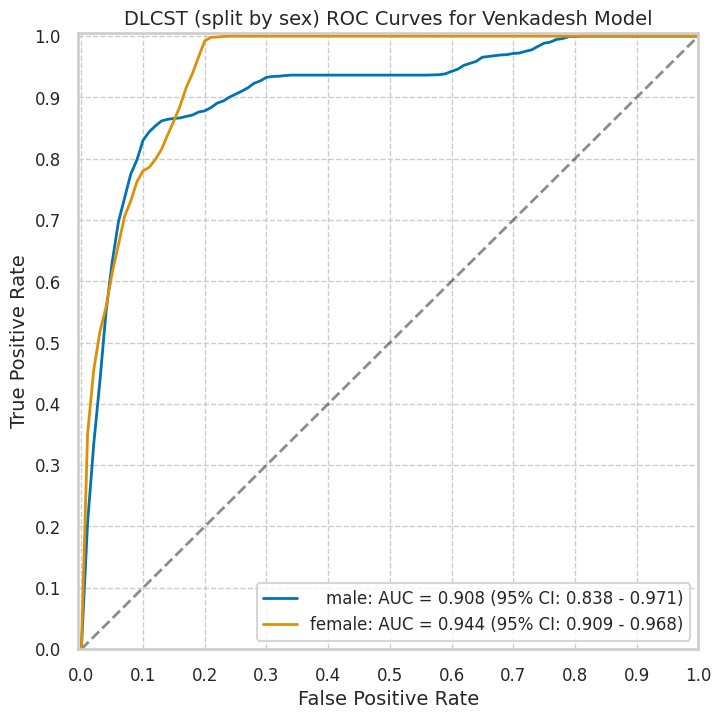

male, n=323
female, n=276


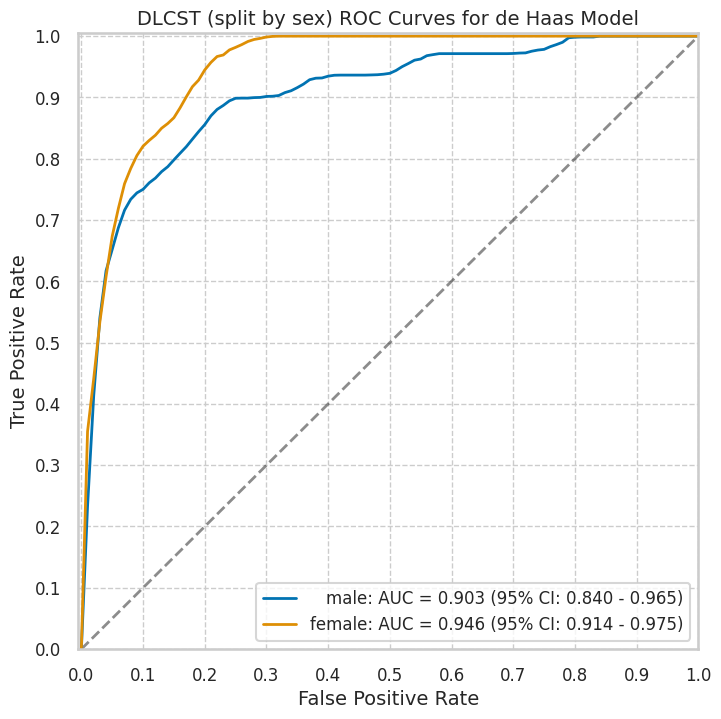

male, n=323
female, n=276


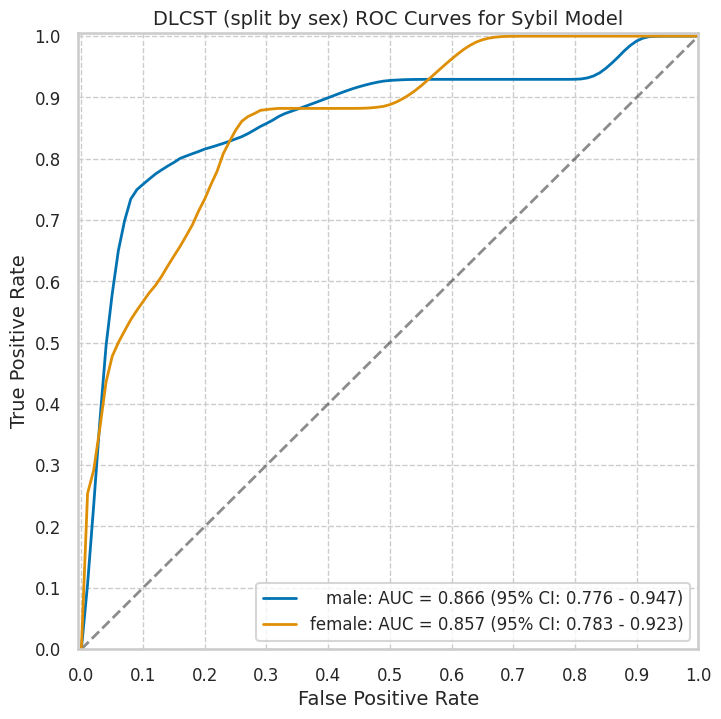

male, n=323
female, n=276


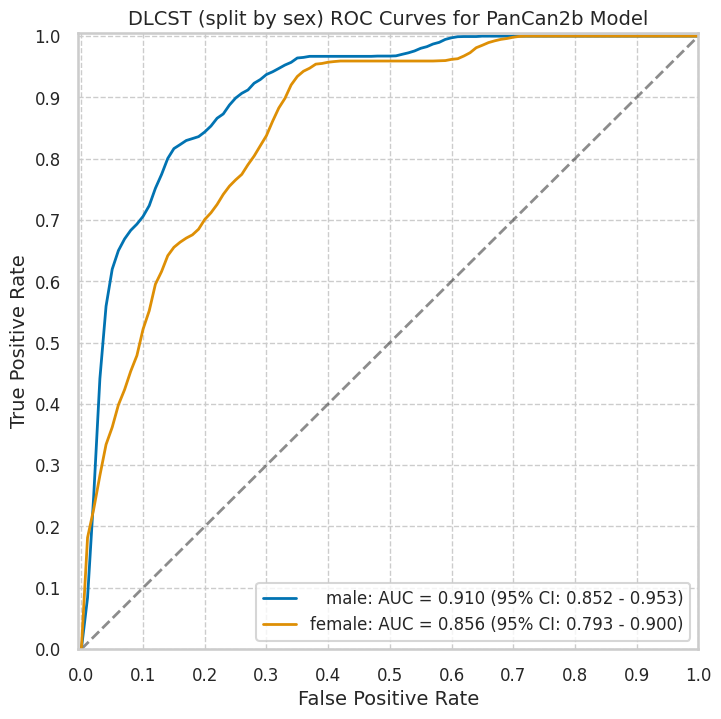

In [18]:
for m in MODEL_TO_COL.keys():
    rocs_splits(df_results, "sex", model=m)

no, n=194
yes, n=405


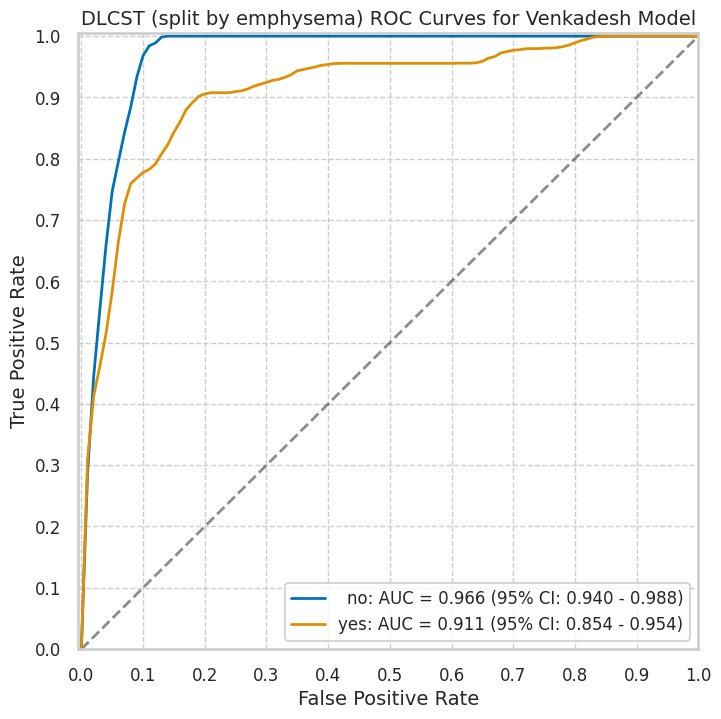

no, n=194
yes, n=405


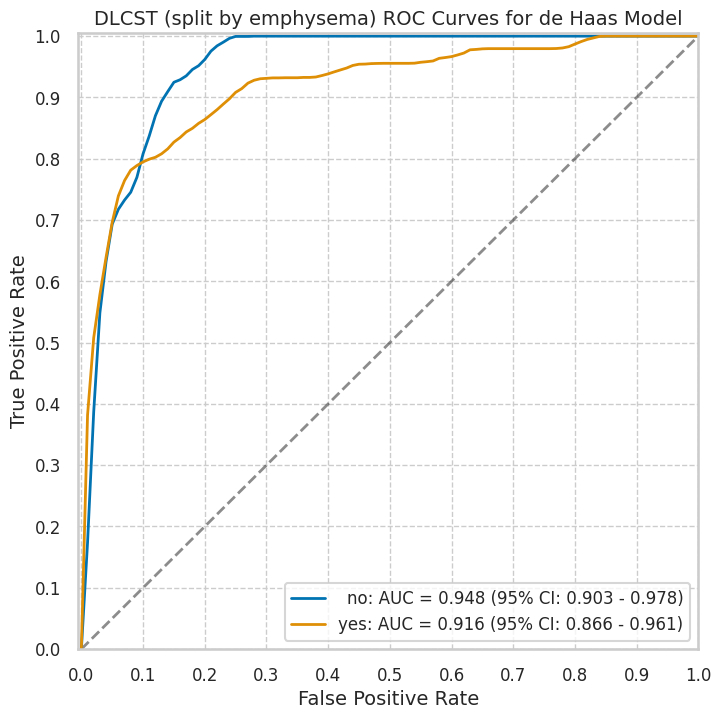

no, n=194
yes, n=405


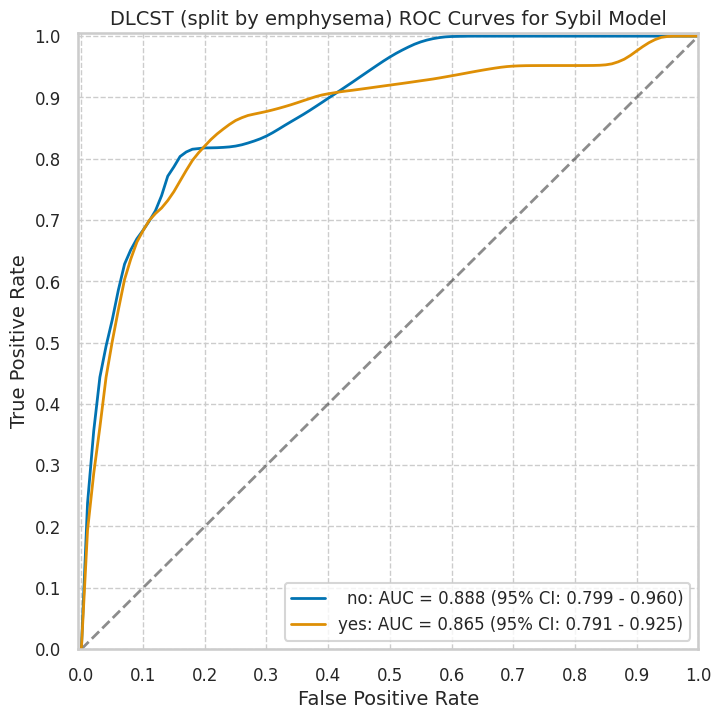

no, n=194
yes, n=405


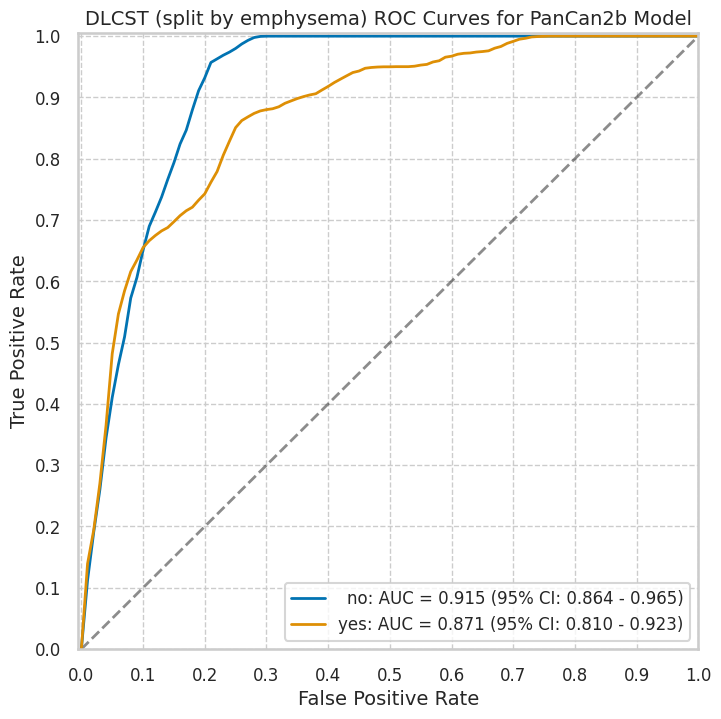

In [19]:
for m in MODEL_TO_COL.keys():
    rocs_splits(df_results, "emphysema", model=m)

no, n=497
yes, n=102


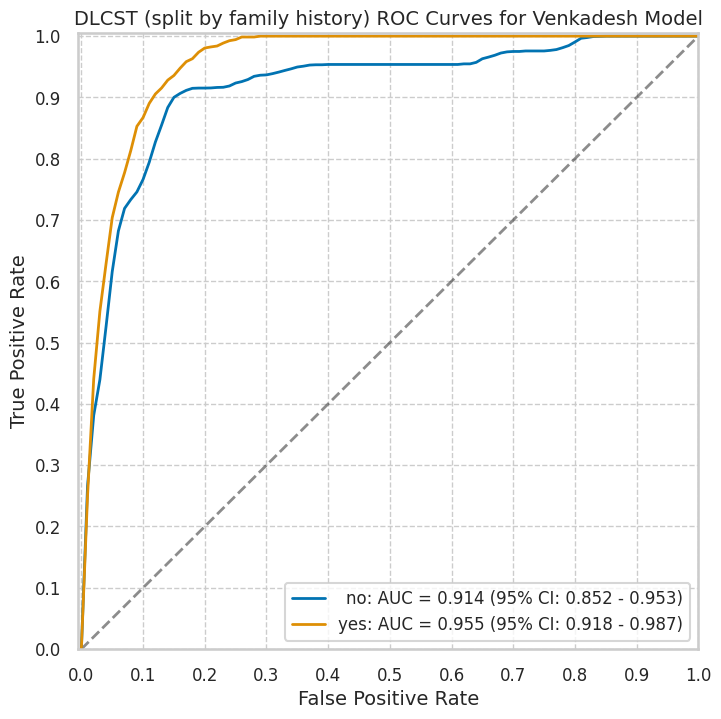

no, n=497
yes, n=102


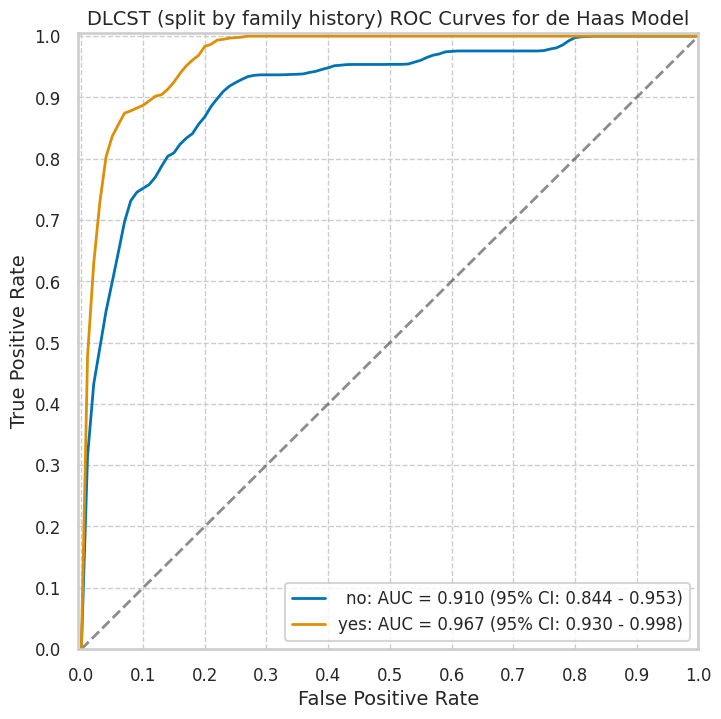

no, n=497
yes, n=102


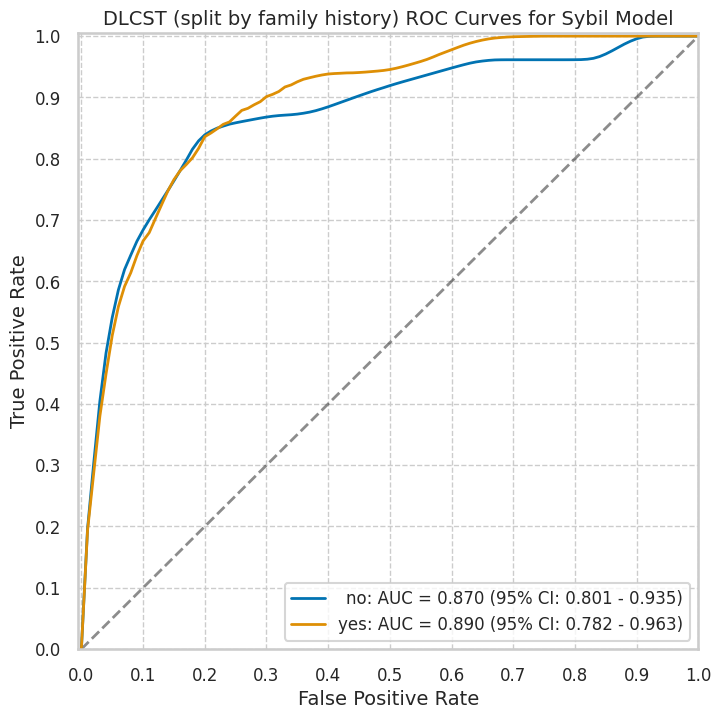

no, n=497
yes, n=102


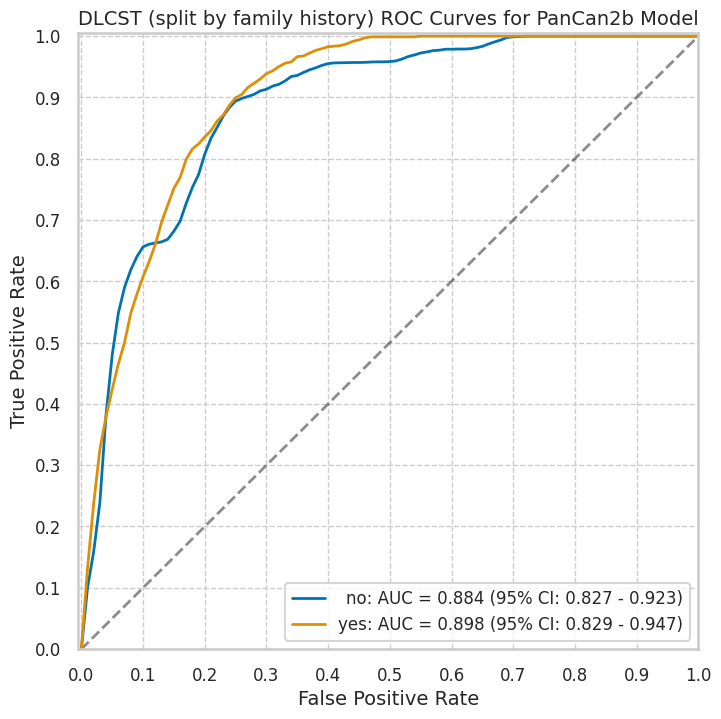

In [20]:
for m in MODEL_TO_COL.keys():
    rocs_splits(df_results, "family history", model=m)

50-55, n=153
55-60, n=186
60-65, n=193
65+, n=67


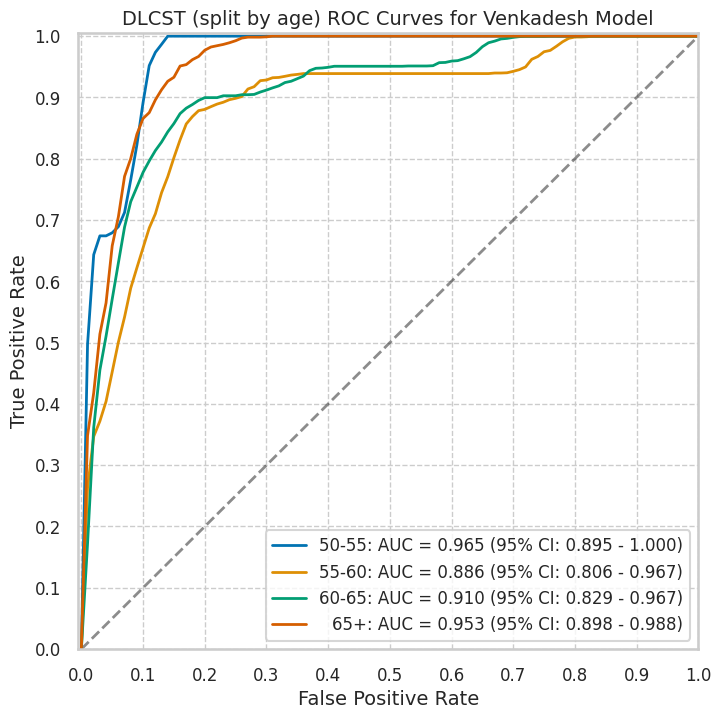

50-55, n=153
55-60, n=186
60-65, n=193
65+, n=67


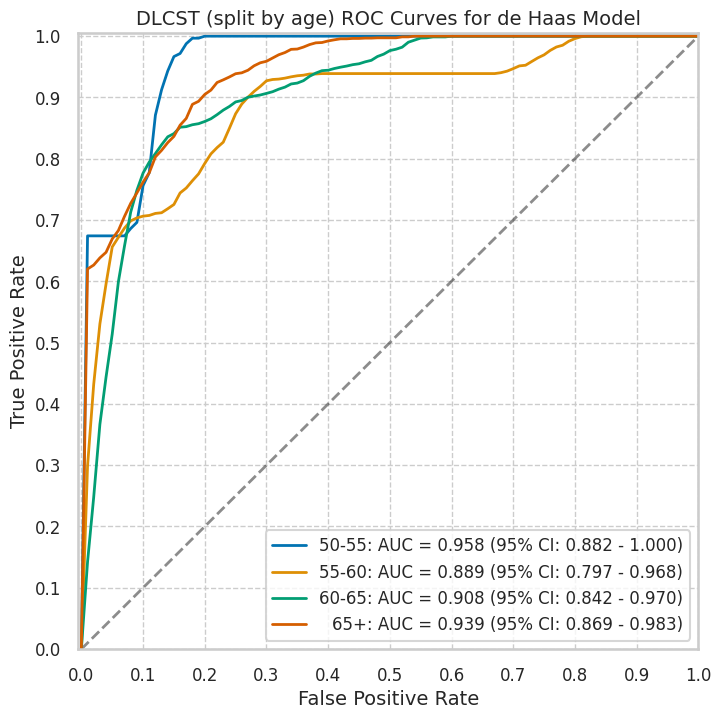

50-55, n=153
55-60, n=186
60-65, n=193
65+, n=67


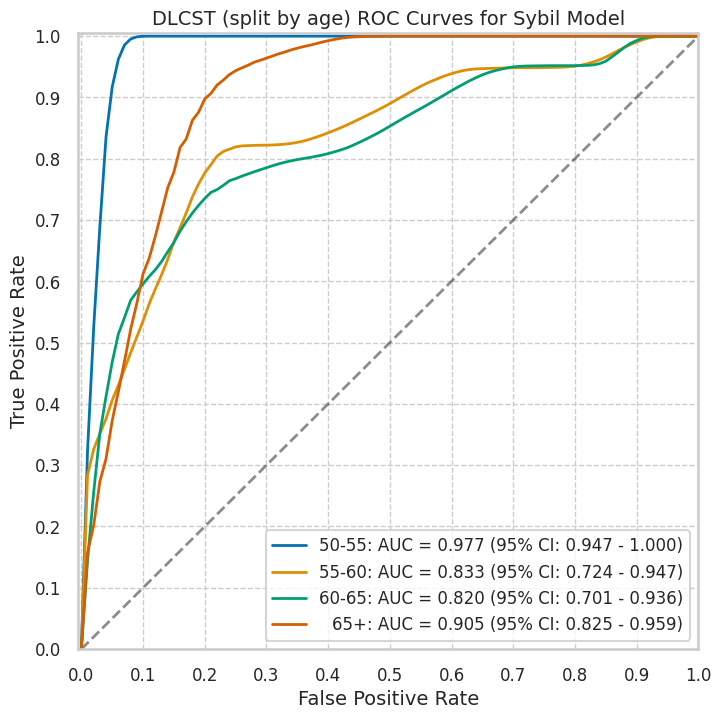

50-55, n=153
55-60, n=186
60-65, n=193
65+, n=67


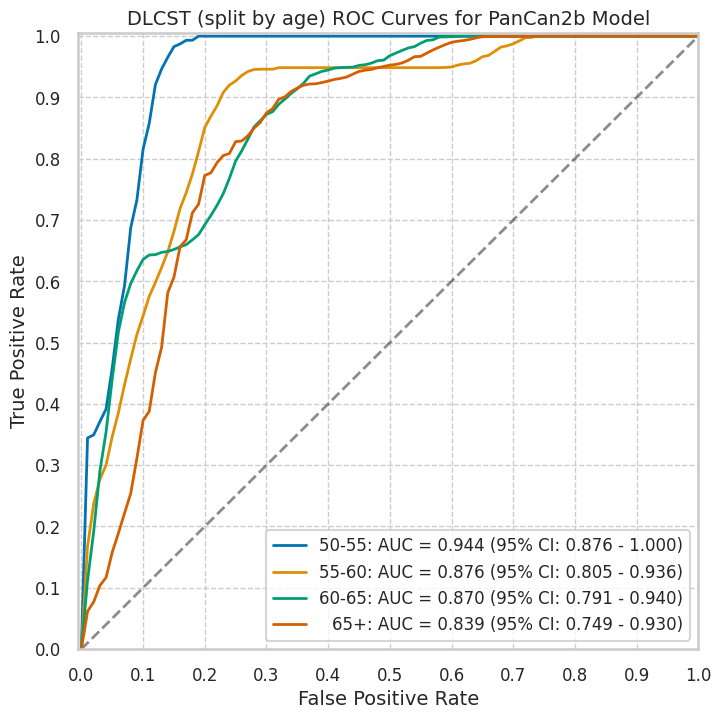

In [21]:
for m in MODEL_TO_COL.keys():
    rocs_splits(df_results, "age", model=m)